In [92]:
!pip install imblearn

In [93]:
#Data Preprocessing and Handling
import pandas as pd
import numpy as np
#EDA / Visualization
import seaborn as sns
import matplotlib.pyplot as plt
#Model Training
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , roc_auc_score


In [94]:
#Loading Data
data = pd.read_csv("/content/diabetes.csv")

In [95]:
#Data View
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [96]:
print(data.isnull().sum())
print(data.info())
print(data.describe())

#Problem :- Some Features can't be 0 :: Glucose , BP , Skin Thickness , BMI , Insulin
#Solution :- Replacing zeros with Mean/Median

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               773 non-null    int64  
 1   Glucose                   773 non-null    int64  
 2   BloodPressure             773 non-null    int64  
 3   SkinThickness             773 non-null    int64  
 4   Insulin                   773 non-null    int64  
 5   BMI                       773 non-null    float64
 6   DiabetesPedigreeFunction  773 non-null    float64
 7   Age                       773 non-null    int64  
 8   Outcome                   773 non-null    int64  
dtypes: 

In [97]:
#Problem Found : Outliers (Mean is Varying very High)
#Solution : Imputing with Median Value
for col in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']:
  print(f"{col} Median:{data[col].median()} Mean:{data[col].mean()}")

Glucose Median:117.0 Mean:120.88874514877102
BloodPressure Median:72.0 Mean:69.11125485122898
SkinThickness Median:23.0 Mean:20.532988357050453
Insulin Median:36.0 Mean:79.80077619663648
BMI Median:32.0 Mean:31.947347994825353


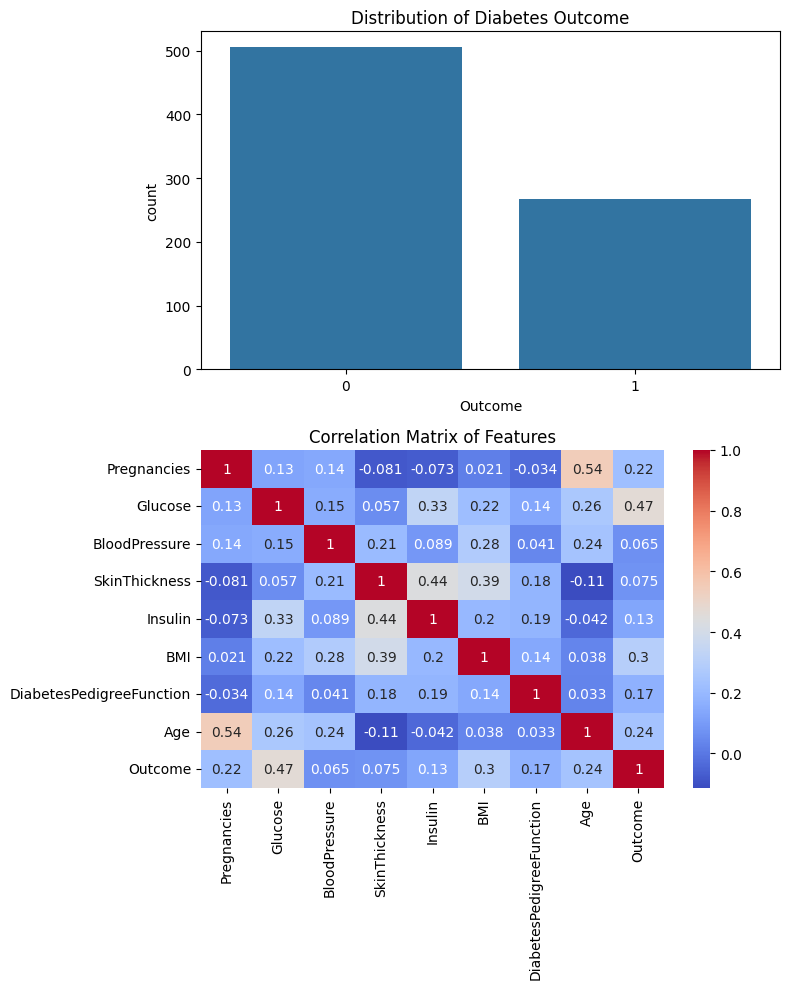

In [98]:
#EDA

figure , (x1,x2) = plt.subplots(2,1,figsize=(8,10))

sns.countplot(x='Outcome', data=data ,ax=x1)
x1.set_title('Distribution of Diabetes Outcome')

correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',ax=x2)
x2.set_title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

#Result : SkinThickness and BloodPressure are least related

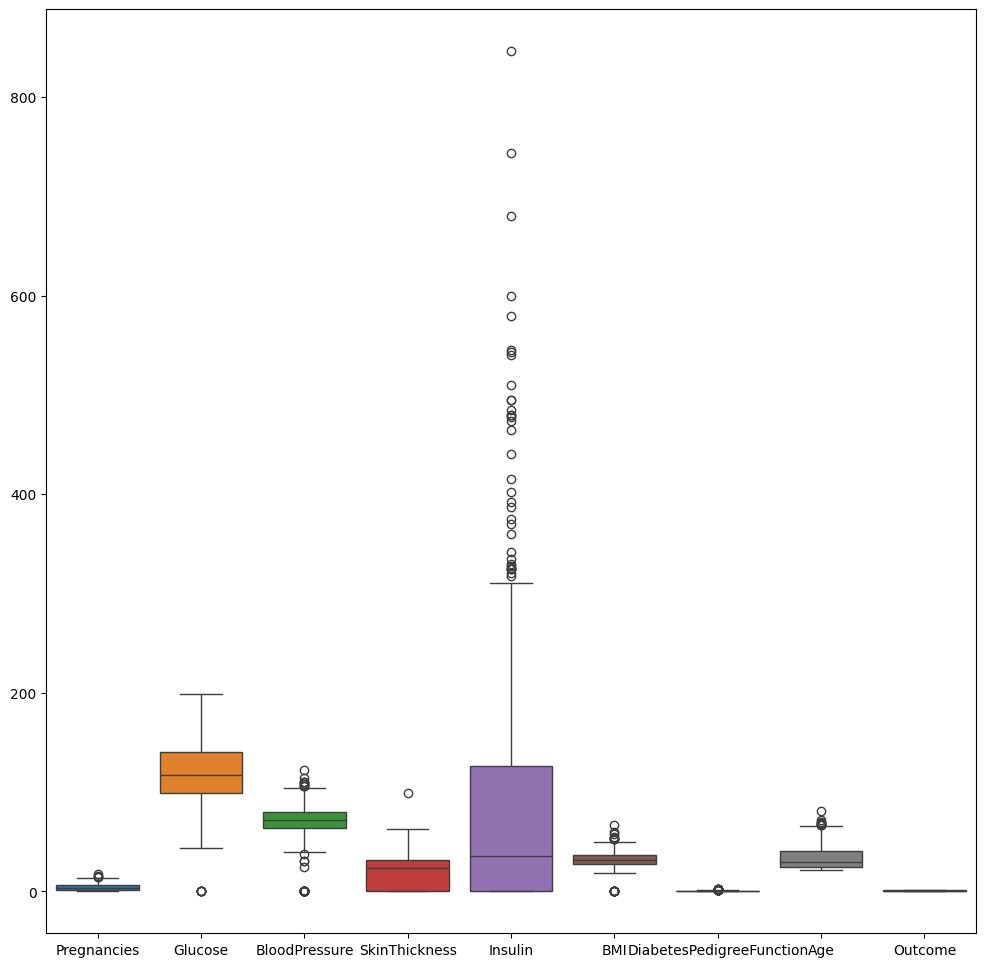

In [99]:
plt.figure(figsize=(12,12))
sns.boxplot(data=data)
plt.show()

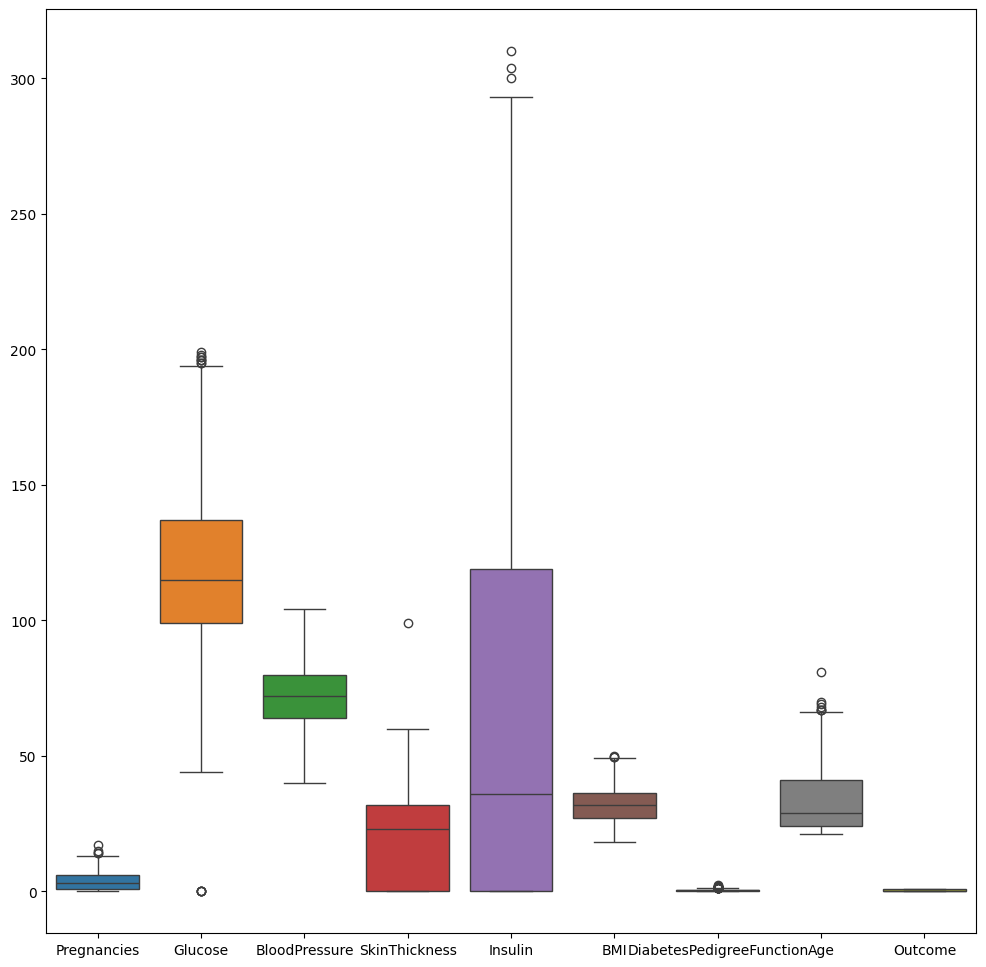

In [100]:
#Removing Outliers from Insulin
Q1 = data['Insulin'].quantile(0.25)
Q2 = data['Insulin'].quantile(0.50)
Q3 = data['Insulin'].quantile(0.75)

IQR = Q3-Q1
UL = Q3 + 1.5*IQR
LL = Q1 - 1.5*IQR

data_new = data[(data['Insulin'] >= LL) & (data['Insulin'] <= UL)]

Q1B = data['BMI'].quantile(0.25)
Q2B = data['BMI'].quantile(0.50)
Q3B = data['BMI'].quantile(0.75)

IQR = Q3B-Q1B
ULB = Q3B + 1.5*IQR
LLB = Q1B - 1.5*IQR

data_new = data_new[(data_new['BMI'] >= LLB) & (data_new['BMI'] <= ULB)]

Q1P = data['BloodPressure'].quantile(0.25)
Q2P = data['BloodPressure'].quantile(0.50)
Q3P = data['BloodPressure'].quantile(0.75)

IQR = Q3P-Q1P
ULP = Q3P + 1.5*IQR
LLP = Q1P - 1.5*IQR

data_new = data_new[(data_new['BloodPressure'] >= LLP) & (data_new['BloodPressure'] <= ULP)]

plt.figure(figsize=(12,12))
sns.boxplot(data=data_new)
plt.show()

In [101]:
#Feature Selection
#Feature Selection

x = data.drop(columns=['Outcome','SkinThickness','BloodPressure'],axis=1)
y = data['Outcome']



In [102]:
#Imputing Zero Values with Median after splitting the data to avoid data leakage into test set

invalid_zero = ['Glucose','Insulin','BMI']

for col in invalid_zero:
  if col in x.columns:
    x[col] = x[col].replace(0,np.nan)

#Data Splitting
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

medians = {}
for col in invalid_zero:
  medians[col] = x_train[col].median()

for col in invalid_zero:
  x_train[col].fillna(medians[col],inplace=True)
  x_test[col].fillna(medians[col],inplace=True)

#Synthetic Minority Oversampling Technique on Training Set
sm = SMOTE(random_state=42,sampling_strategy='minority')
x_train,y_train = sm.fit_resample(x_train,y_train)


/tmp/ipython-input-1764902222.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train[col].fillna(medians[col],inplace=True)
/tmp/ipython-input-1764902222.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [103]:
x_train.head(20)

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
0,4,99.0,123.5,32.8,0.145,33
1,4,122.0,123.5,35.0,0.394,29
2,4,197.0,744.0,36.7,2.329,31
3,5,104.0,123.5,28.8,0.153,48
4,0,99.0,123.5,25.0,0.253,22
5,4,146.0,123.5,38.5,0.520,67
6,3,111.0,123.5,30.1,0.557,30
7,1,164.0,67.0,32.8,0.341,50
8,4,117.0,123.5,29.7,0.380,30
9,12,100.0,105.0,30.0,0.488,46


In [104]:
y_train.head(20)

,Outcome
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,1
9,0


In [105]:
x.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,NaN,33.6,0.627,50
1,1,85.0,NaN,26.6,0.351,31
2,8,183.0,NaN,23.3,0.672,32
3,1,89.0,94.0,28.1,0.167,21
4,0,137.0,168.0,43.1,2.288,33


In [106]:
#Scaling
#(Scaling before Splitting can expose the testing set to the model leading to poor performance by calculating global tendencies like mean , median etc.
# Using transform on test data after using fit_transform on training data will use the same measures that was remembered from training phase making model Generalized. )

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


--- Performing 5-fold Cross-Validation for Model Selection ---
Logistic Regression: Mean Accuracy = 0.7253 (Std: 0.0236)
SVM: Mean Accuracy = 0.7896 (Std: 0.0268)
Random Forest: Mean Accuracy = 0.8244 (Std: 0.0573)


/tmp/ipython-input-636045615.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


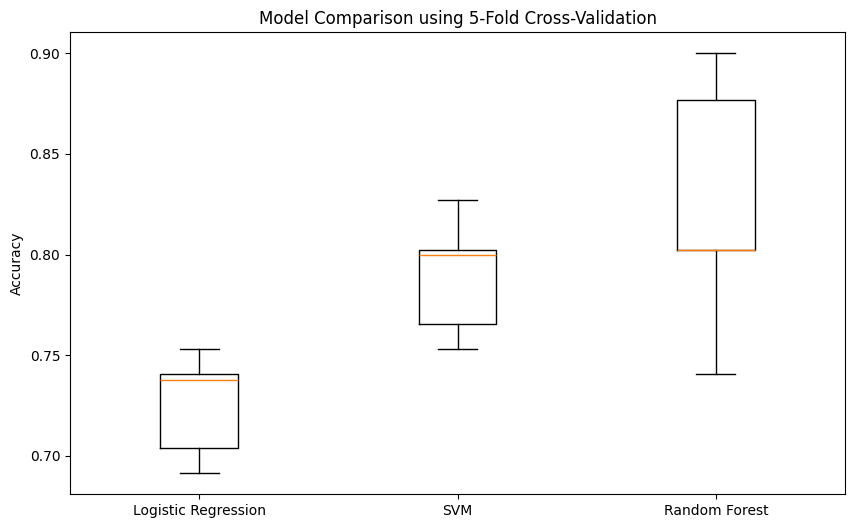

In [107]:
#Model Selection using K-Fold Cross Validation

# 1. Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,class_weight="balanced"),
    "SVM": SVC(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42,class_weight="balanced")
}

# 2. Dictionary to store results
results = {}

# 3. Loop through each model and perform cross-validation
print("\n--- Performing 5-fold Cross-Validation for Model Selection ---")
for name, model in models.items():
    # Use cross_val_score to get scores for 5 folds
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='recall')
    results[name] = cv_scores
    print(f"{name}: Mean Accuracy = {cv_scores.mean():.4f} (Std: {cv_scores.std():.4f})")

# 4. Visualize the results to easily compare models
plt.figure(figsize=(10, 6))
plt.boxplot(results.values(), labels=results.keys())
plt.title('Model Comparison using 5-Fold Cross-Validation')
plt.ylabel('Accuracy')
plt.show()


#Result : RandomForest is selected

In [108]:
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2']         # Number of features to consider when looking for the best split
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='recall')

grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [109]:
#Training RandomForest Model

model = grid_search.best_estimator_
model.fit(x_train,y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [110]:
#Predicting and Evaluating

result = model.predict(x_test)

In [111]:
print("Accuracy : ",accuracy_score(y_test,result))
print("Recall : ",recall_score(y_test,result))
print("Precision : ",precision_score(y_test,result))
print("F1 Score : ",f1_score(y_test,result))

Accuracy :  0.7483870967741936
Recall :  0.6666666666666666
Precision :  0.631578947368421
F1 Score :  0.6486486486486487


In [112]:
confusion_matrix(y_test,result)

array([[80, 21],
       [18, 36]])

In [113]:
# Model Saving
import joblib as jb

artifacts = {
    "model": model,
    "scaler": scaler,
    "medians": medians,
    "feature_order": list(x.columns)  # Order before transformations; matches manual input creation
}

jb.dump(artifacts, "diabetes_artifacts.pkl")
print("Saved model + scaler + medians to diabetes_artifacts.pkl")

Saved model + scaler + medians to diabetes_artifacts.pkl


In [114]:
#test = model.predict(np.array([0,50,40,20,25,0,21]).reshape(1,-1))
# Manual input example (match the feature_order exactly)
manual_input_dict = {
    "Pregnancies": 2,
    "Glucose": 150,
    "Insulin": 100,
    "BMI": 29,
    "DiabetesPedigreeFunction": 1.45,
    "Age": 45
}

# Build DataFrame in correct column order
manual_df = pd.DataFrame([[manual_input_dict[col] for col in artifacts["feature_order"]]],
                         columns=artifacts["feature_order"])

# Zero -> NaN replacement for invalid zero columns
for col in invalid_zero:
    if col in manual_df.columns:
        manual_df[col] = manual_df[col].replace(0, np.nan)

# Fill NaNs with training medians
for col in invalid_zero:
    if col in manual_df.columns:
        manual_df[col].fillna(artifacts["medians"][col], inplace=True)

# Scale using stored scaler
manual_scaled = artifacts["scaler"].transform(manual_df)

# Predict
manual_pred = artifacts["model"].predict(manual_scaled)[0]
print("Manual input prediction:", manual_pred)


Manual input prediction: 1


/tmp/ipython-input-492236048.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  manual_df[col].fillna(artifacts["medians"][col], inplace=True)
